# Task 1

Load and configure the needed modules.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint

# inline plots
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Load the MNIST data, shuffled and split between train and test sets. Additionally, we are going to take 10% of the entire training set as the validation set and leave the remaining 90% as the training set.

In [8]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

batch_size = 128
nb_classes = 10
nb_epoch = 10

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

Add random noise

In [21]:
std = .2
gaussian_noise_train = np.random.normal(0,std,X_train.shape)
gaussian_noise_test = np.random.normal(0,std,X_test.shape)

X_train_noise = X_train - gaussian_noise_train
X_test_noise = X_test - gaussian_noise_test

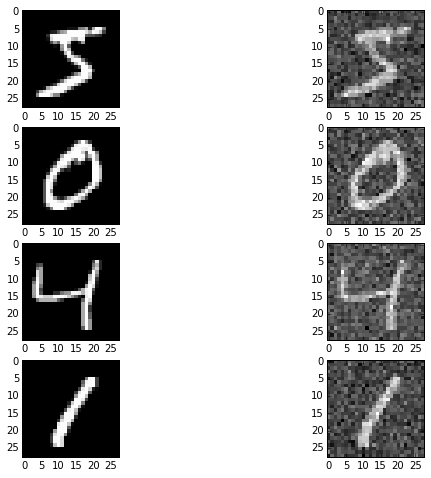

In [22]:
f, axarr = plt.subplots(4, 2)
for i in range(4):
    axarr[i,0].imshow(X_train[i])
    axarr[i,1].imshow(X_train_noise[i])

## Convolutional Neural Network

We need to reshape the images into vectors, convert the pixel values to float numbers and divide by 255 so that the values are between 0 and 1.

In [40]:
X_train_noise = X_train_noise.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test_noise = X_test_noise.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
print('X_train shape:', X_train_noise.shape)
print(X_train_noise.shape[0], 'train samples')
print(X_test_noise.shape[0], 'test samples')

('X_train shape:', (60000, 1, 28, 28))
(60000, 'train samples')
(10000, 'test samples')


We also need to convert the class labels to binary vectors. See below a couple of examples of what this means.

In [24]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

First let's try with a simple architecture consisting of two fully connected layers with 32 neurons followed by relu activations, and a third fully connected layer with 10 neurons followed by a softmax function to produce the class scores.

In [25]:
model = Sequential()

model.add(Convolution2D(32, nb_conv, nb_conv,
                        border_mode='valid',
                        activation='relu',
                        input_shape=(1, img_rows, img_cols),
                        name='conv1_1'))
model.add(Convolution2D(32, nb_conv, nb_conv, activation='relu', name='conv1_2'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool), name='pool1'))
model.add(Convolution2D(64, nb_conv, nb_conv, activation='relu', name='conv2'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool), name='pool2'))

model.add(Flatten())
model.add(Dense(128, activation='relu', name='fc1'))
model.add(Dense(nb_classes, activation='softmax', name='output'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
conv1_1 (Convolution2D)            (None, 32, 26, 26)  320         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
conv1_2 (Convolution2D)            (None, 32, 24, 24)  9248        conv1_1[0][0]                    
____________________________________________________________________________________________________
pool1 (MaxPooling2D)               (None, 32, 12, 12)  0           conv1_2[0][0]                    
____________________________________________________________________________________________________
conv2 (Convolution2D)              (None, 64, 10, 10)  18496       pool1[0][0]                      
___________________________________________________________________________________________

In [26]:
callbacks = [
    ModelCheckpoint('./weights_noise.hdf5', save_best_only=True),
    EarlyStopping(patience=1)
]

history = model.fit(X_train_noise, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_test_noise, Y_test), callbacks=callbacks)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 295s - loss: 0.1774 - acc: 0.9459 - val_loss: 0.0419 - val_acc: 0.9861
Epoch 2/10
60000/60000 [==============================] - 285s - loss: 0.0443 - acc: 0.9862 - val_loss: 0.0332 - val_acc: 0.9891
Epoch 3/10
60000/60000 [==============================] - 292s - loss: 0.0286 - acc: 0.9910 - val_loss: 0.0336 - val_acc: 0.9899
Epoch 4/10
60000/60000 [==============================] - 334s - loss: 0.0192 - acc: 0.9940 - val_loss: 0.0396 - val_acc: 0.9873


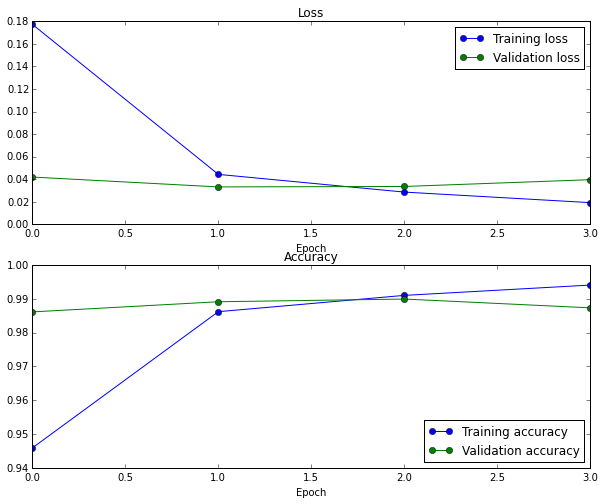

In [27]:
plt.subplot(2, 1, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.plot(history.history['loss'], '-o', label='Training loss')
plt.plot(history.history['val_loss'], '-o', label='Validation loss')
plt.legend(loc='upper right')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.plot(history.history['acc'], '-o', label='Training accuracy')
plt.plot(history.history['val_acc'], '-o', label='Validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [53]:
model.evaluate(X_test, Y_test)

10000/10000 [==============================] - 18s    


[0.034707620646443685, 0.98999999999999999]

Since we are using checkpointing, we can take the model that performs best on the validation set and evaluate it on the test set.

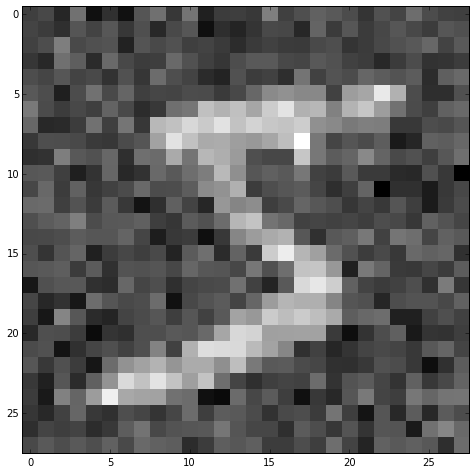

In [29]:
plt.imshow(X_train_noise[0][0], cmap='gray')

In [30]:
filters = model.layers[0].get_weights()[0]
print filters.shape

(32, 1, 3, 3)


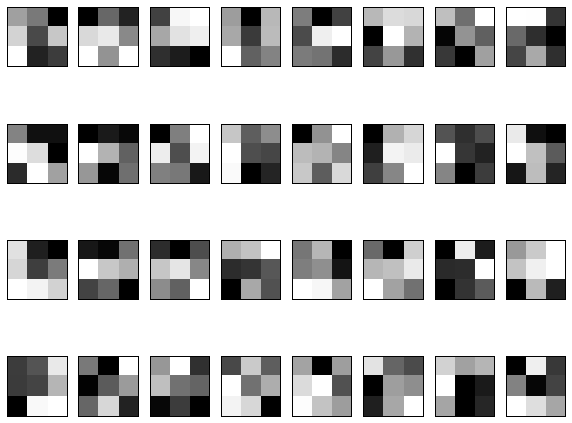

In [31]:
import numpy as np
filters = filters.reshape(4, 8, 3, 3)

f, axarr = plt.subplots(4, 8)
for i in range(4):
    for j in range(8):
        axarr[i, j].imshow(filters[i,j], cmap='gray')
        axarr[i,j].get_xaxis().set_visible(False)
        axarr[i,j].get_yaxis().set_visible(False)

In [45]:
from keras import backend as K

get_1st_layer_output = K.function([model.layers[0].input],
                                  [model.layers[0].output])
get_2nd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[1].output])
get_4th_layer_output = K.function([model.layers[0].input],
                                  [model.layers[3].output])
output_noise = []
output_noise.append(get_1st_layer_output([X_test_noise[:1]])[0])
output_noise.append(get_2nd_layer_output([X_test_noise[:1]])[0])
output_noise.append(get_4th_layer_output([X_test_noise[:1]])[0])
output = []
output.append(get_1st_layer_output([X_test[:1]])[0])
output.append(get_2nd_layer_output([X_test[:1]])[0])
output.append(get_4th_layer_output([X_test[:1]])[0])

Conv layer 1
With Noise


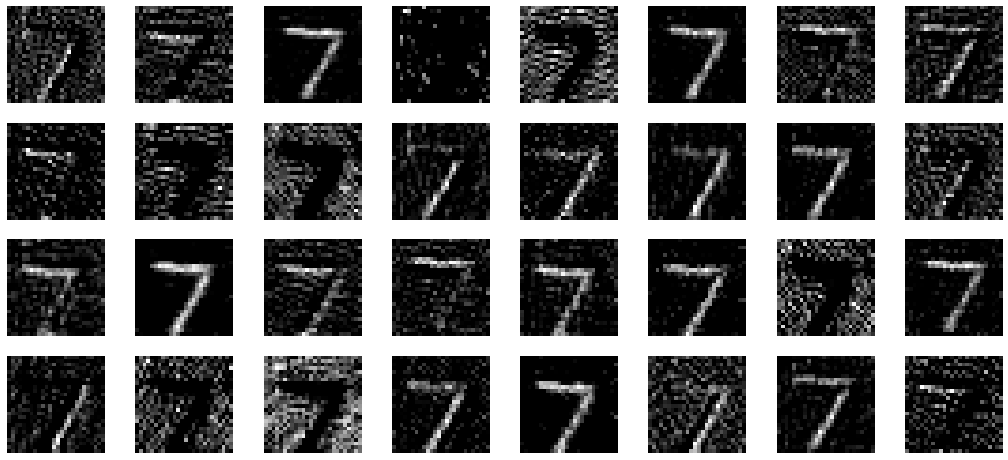

Without Noise


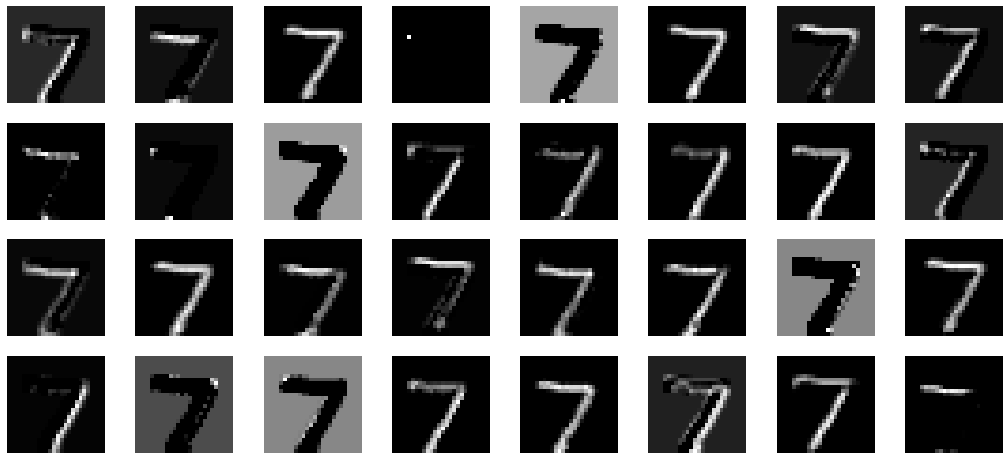

Conv layer 2
With Noise


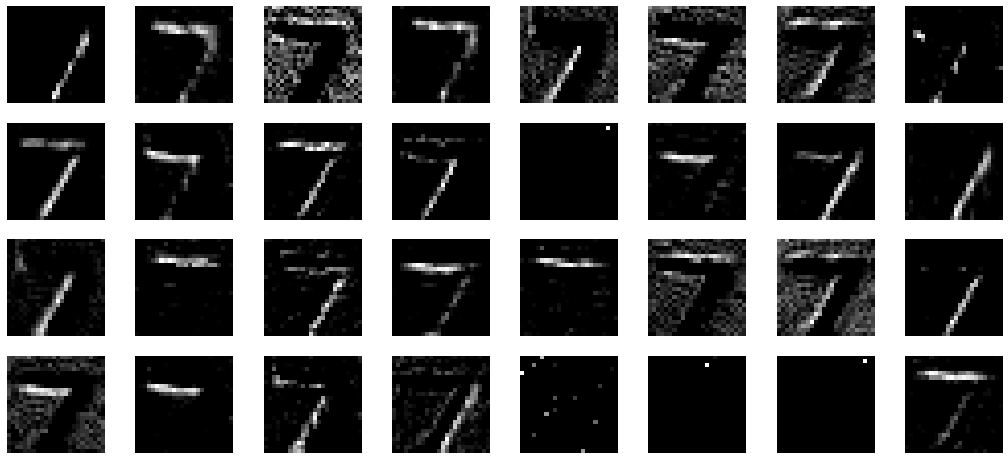

Without Noise


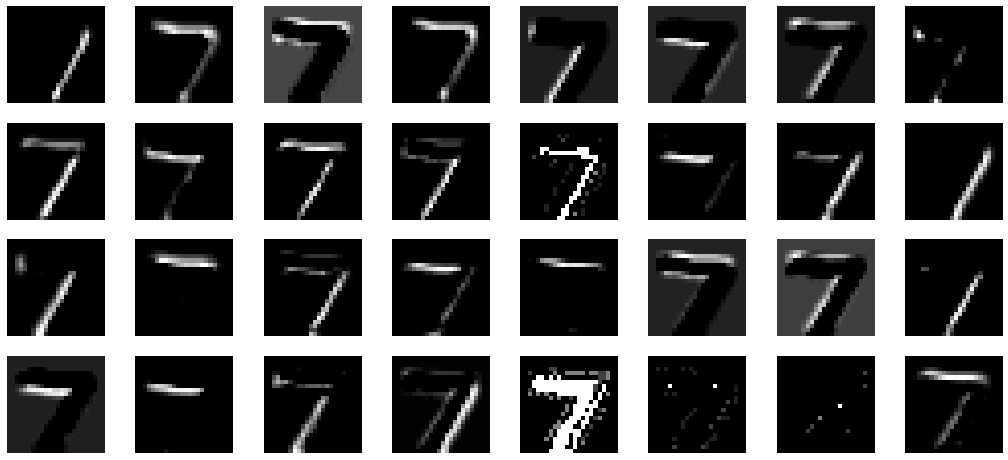

Conv layer 3
With Noise


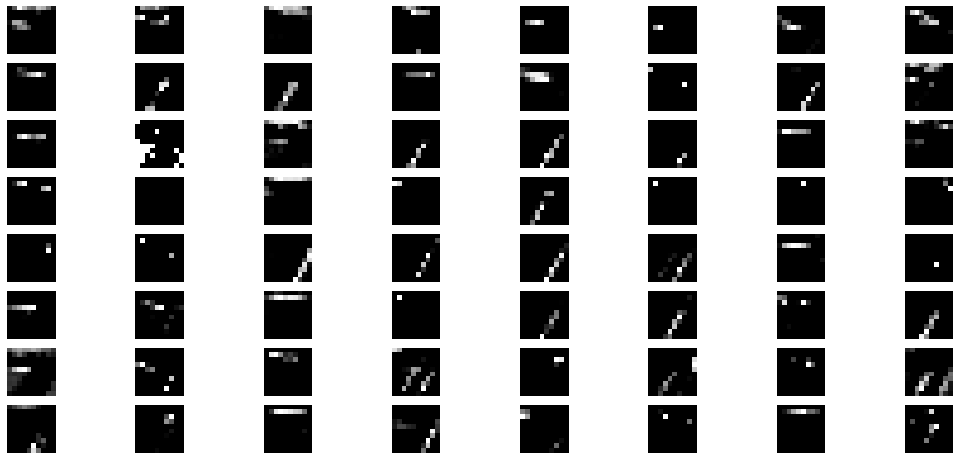

Without Noise


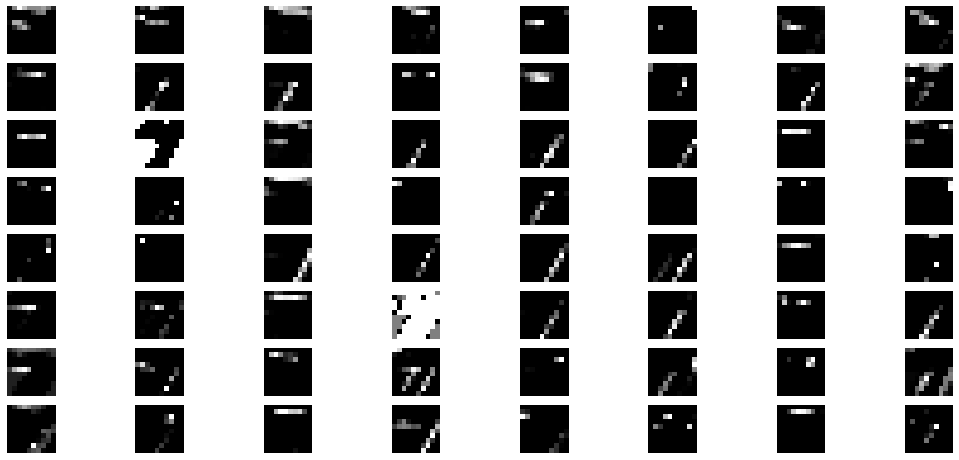

In [54]:
for i in range(3):
    #plt.figure(figsize=(18, 8), dpi=100)
    print('Conv layer {}'.format(i+1))
    print('With Noise')
    out_n = output_noise[i]
    out_n = out_n.reshape(-1, 8, out_n.shape[-2], out_n.shape[-1])
    f, axarr = plt.subplots(out_n.shape[0], 8, figsize=(18, 8), dpi=100)
    for k in range(out_n.shape[0]):
        for j in range(8):
            axarr[k, j].imshow(out_n[k,j], cmap='gray')
            axarr[k,j].get_xaxis().set_visible(False)
            axarr[k,j].get_yaxis().set_visible(False)
    plt.show()
    out = output[i]
    out = out.reshape(out_n.shape)
    print('Without Noise')
    f, axarr = plt.subplots(out.shape[0], 8, figsize=(18, 8), dpi=100)
    for i in range(out.shape[0]):
        for j in range(8):
            axarr[i, j].imshow(out[i,j], cmap='gray')
            axarr[i,j].get_xaxis().set_visible(False)
            axarr[i,j].get_yaxis().set_visible(False)
    plt.show()

Conv layer 1


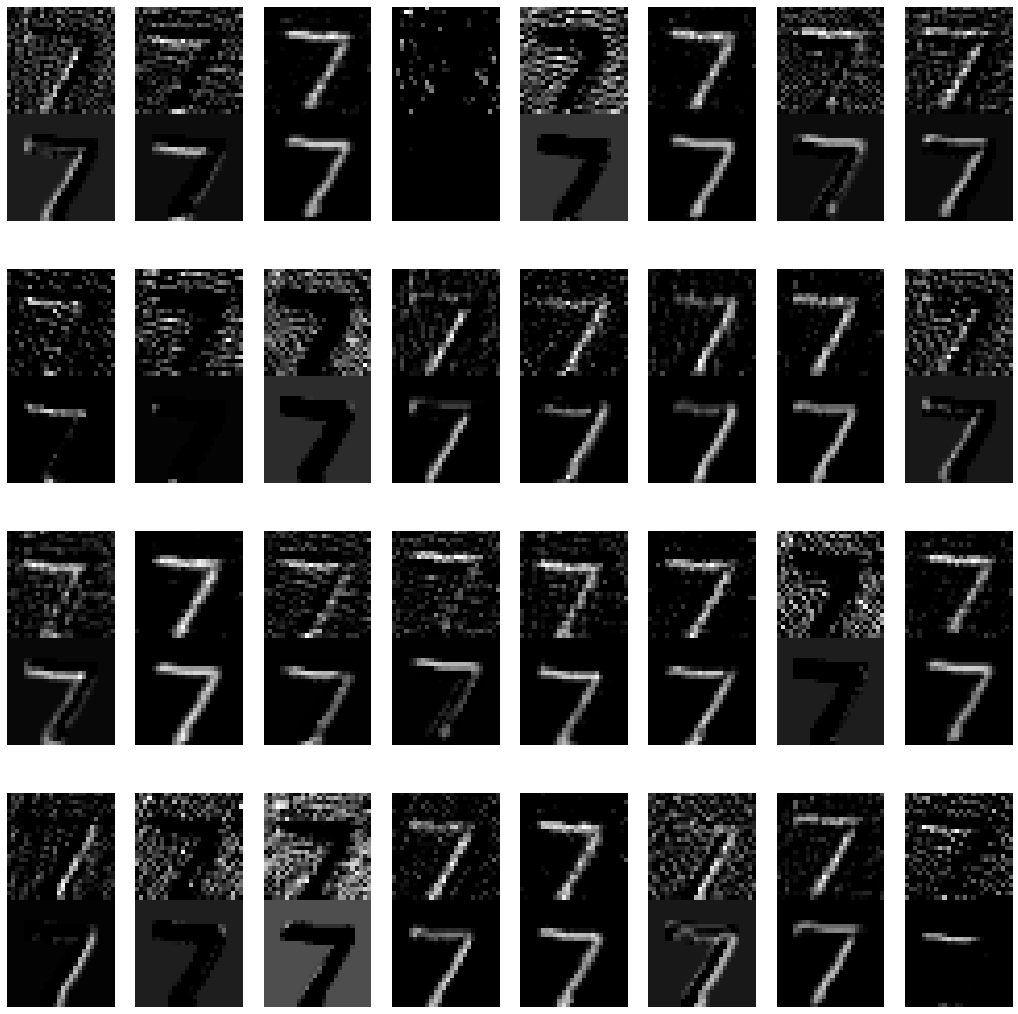

Conv layer 2


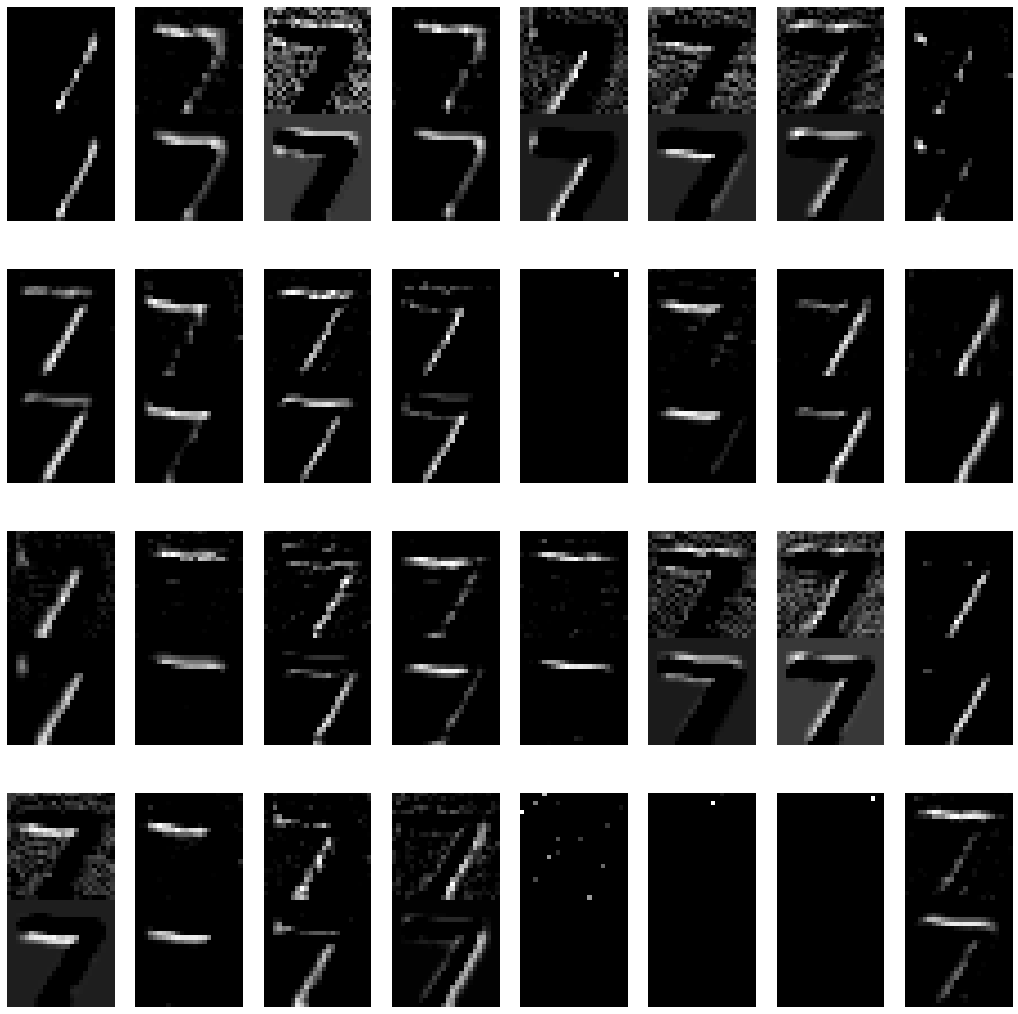

Conv layer 3


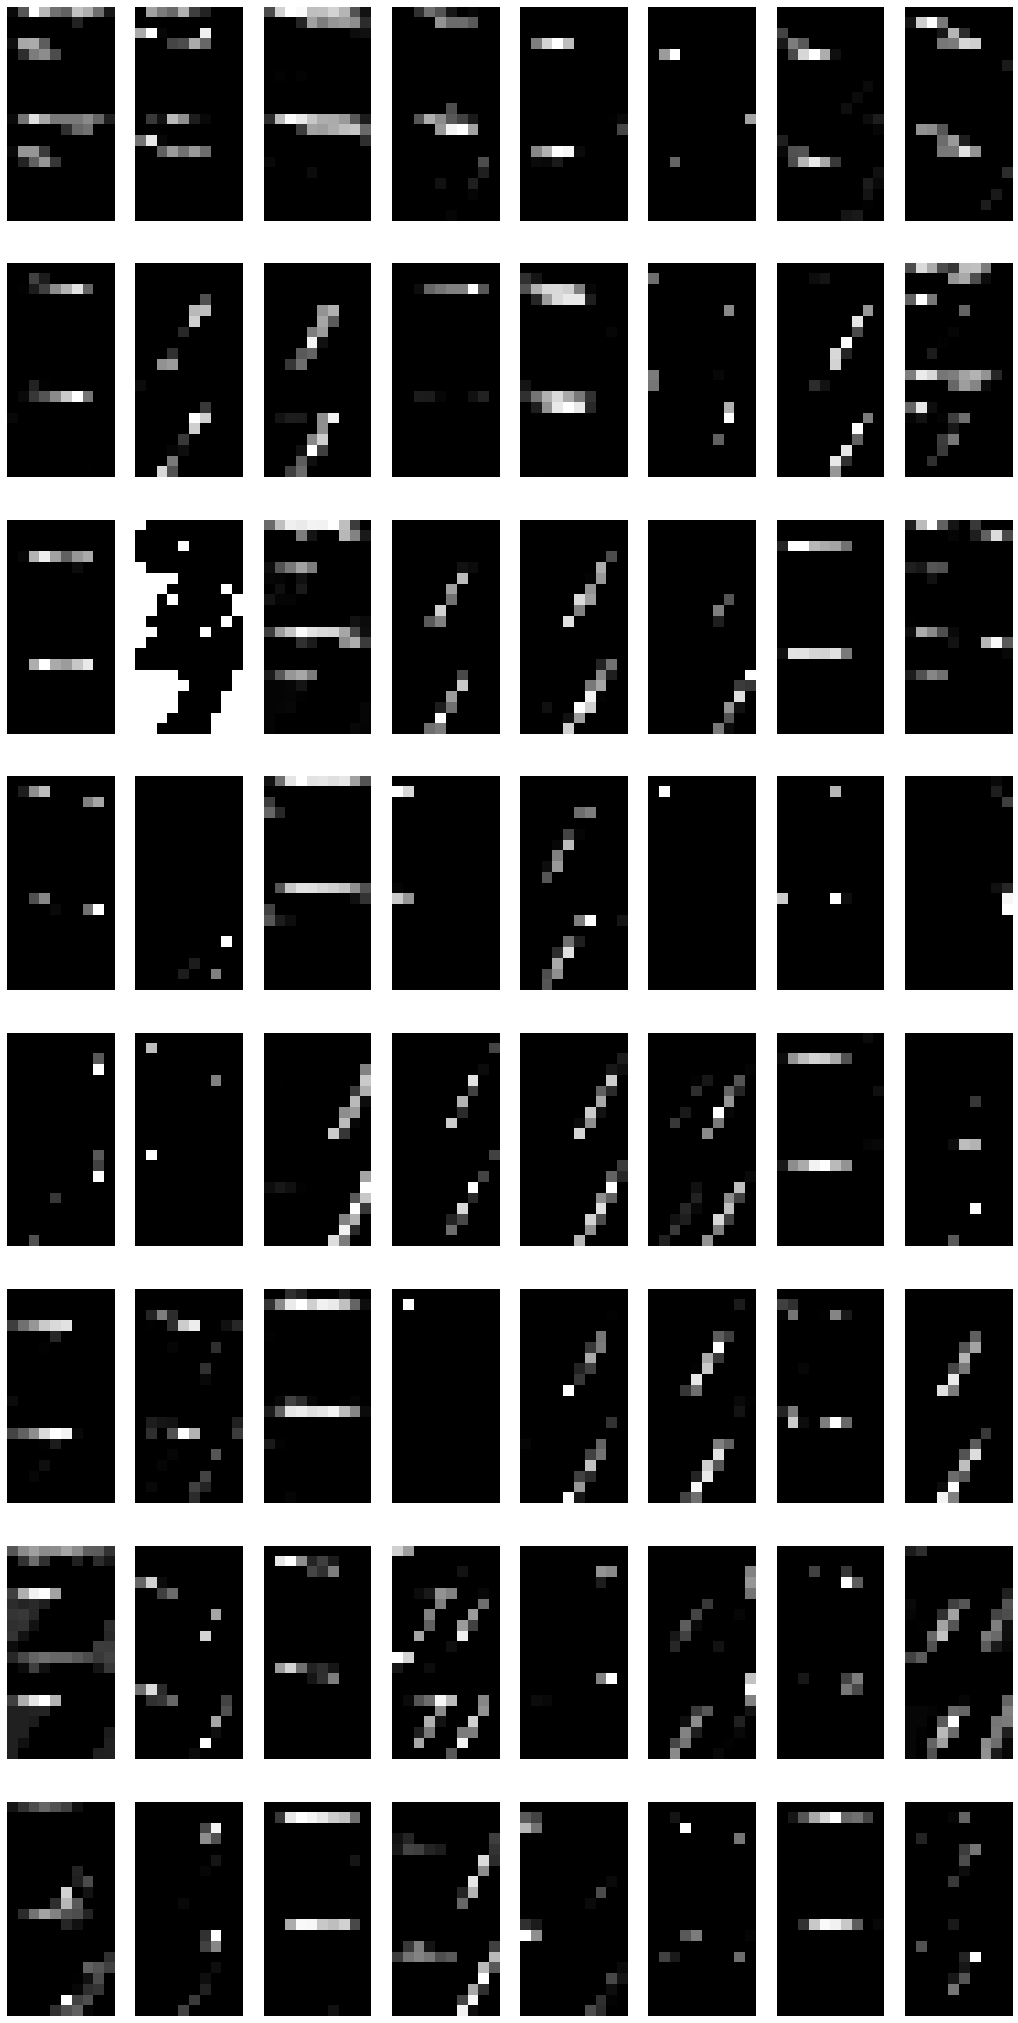

In [67]:
for i in range(3):
    #plt.figure(figsize=(18, 8), dpi=100)
    print('Conv layer {}'.format(i+1))
    out_n = output_noise[i]
    out_n = out_n.reshape(-1, 8, out_n.shape[-2], out_n.shape[-1])
    out = output[i]
    out = out.reshape(out_n.shape)
    f, axarr = plt.subplots(out_n.shape[0], 8, figsize=(18, 18*(1*(i<2) + 2*(i==2))), dpi=100)
    for k in range(out_n.shape[0]):
        for j in range(8):
            axarr[k, j].imshow(np.concatenate((out_n[k,j],out[k,j]), axis=0), cmap='gray')
            axarr[k,j].get_xaxis().set_visible(False)
            axarr[k,j].get_yaxis().set_visible(False)
    plt.show()

### T-SNE

In [37]:
import numpy as np
from sklearn.manifold import TSNE
from keras import backend as K

get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[6].output])
layer_output = get_3rd_layer_output([X_test_noise])[0]
assert layer_output.shape[-1] == 128

layer_output.shape


(10000, 128)

In [38]:
X = layer_output[:3000,:]
model_tsne = TSNE(n_components=2, random_state=0)
Y = model_tsne.fit_transform(X)

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


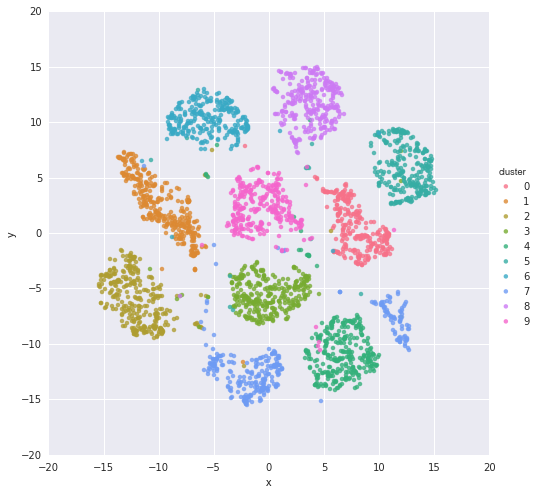

In [39]:
import pandas as pd
import seaborn as sns

data = {"x": [], "y": [], "cluster": []}
for i in range(len(X)):
    data["x"].append(Y[i][0])
    data["y"].append(Y[i][1])
    data["cluster"].append(y_test[i])
df = pd.DataFrame(data)
sns.lmplot("x", "y", data=df,
           fit_reg=False, size=7,
           hue="cluster", legend=True)
plt.show()